Este cuaderno resume el procedimiento llevado a cabo ......

Estos son todos los paquetes empleados para la implementación:

In [1]:
%pylab inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn import svm

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


1) Se importan los datos suministrados por Kaggle [PONER LINK]

In [2]:
data_train = pd.read_csv(os.path.join('.','train.csv'))
data_test = pd.read_csv(os.path.join('.','test.csv'))

2) Para ver el formato en el que vienen los datos:

In [3]:
data_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
706,707,1,2,"Kelly, Mrs. Florence ""Fannie""",female,45.0,0,0,223596,13.5000,NaN,S
348,349,1,3,"Coutts, Master. William Loch ""William""",male,3.0,1,1,C.A. 37671,15.9000,NaN,S
346,347,1,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S
217,218,0,2,"Jacobsohn, Mr. Sidney Samuel",male,42.0,1,0,243847,27.0000,NaN,S
91,92,0,3,"Andreasson, Mr. Paul Edvin",male,20.0,0,0,347466,7.8542,NaN,S
600,601,1,2,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",female,24.0,2,1,243847,27.0000,NaN,S
265,266,0,2,"Reeves, Mr. David",male,36.0,0,0,C.A. 17248,10.5000,NaN,S
269,270,1,1,"Bissette, Miss. Amelia",female,35.0,0,0,PC 17760,135.6333,C99,S
649,650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,CA. 2314,7.5500,NaN,S


3) Se pueden usar diferentes tipos de gráficas para visualizar los diferentes datos, para así tener una primera aproximación entre la relación entre las características y la supervivencia de cada pasajero.

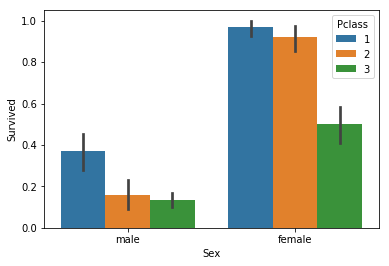

In [4]:
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=data_train);

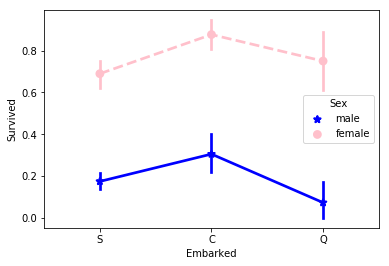

In [5]:
sns.pointplot(x="Embarked", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

4) Se modifican algunas características suministradas para simplificarlas o para organizarlas de manera más efectiva.

4.1) Para las edades se crean grupos dados los rango de edades suministrados:

In [6]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df


4.2) Para la caracteristica de cabinas se elije únicamente el primer elemento, que corresponde a la letra de la zona en la que encontraba la cabina y se asume que el número es irrelevante.

In [7]:
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

In [8]:
def fix_embarked(df):
    df.Embarked = df.Embarked.fillna('U')
    return df

4.3) Para las tarifas que pagó cada persona se hace un análisis etadístico y se agrupan dependiendo el cuartil al que pertenezcan.

In [9]:
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

4.4) Para los nombres se va a tener en cuenta únicamente el apellido y el prefijo cono (Mr., Mrs., etc.). [En el código original se separaban los atributos según los espacios, pero esto fallaba para apellidos compuestos como Vander Cruyssen, por lo tanto, se implementa este código corregido].

In [10]:
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(',')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(',')[1])
    df['NamePrefix'] = df.NamePrefix.apply(lambda x: x.split(' ')[1])
    return df    

4.5) Por último se eliminan datos que no se incluiran en el análisis como número de tiquete y nombre. [En el código original se quitaba también el lugar de embarcación, pero dada la vista en la segunda gráfica de l punto 3) se decide dejar esta característica].

In [11]:
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1)

5) Se hace implementa una función general para realizar todo el manejo de los datos.

In [12]:
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = fix_embarked(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [13]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_test.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
246,1138,2,female,Student,0,0,3_quartile,N,S,Karnes,Mrs.
250,1142,2,female,Baby,1,2,3_quartile,N,S,West,Miss.
354,1246,3,female,Baby,1,2,3_quartile,N,S,Dean,Miss.
304,1196,3,female,Unknown,0,0,1_quartile,N,Q,McCarthy,Miss.
130,1022,3,male,Young Adult,0,0,2_quartile,N,S,Spinner,Mr.


6) Se muestran los resultados de la simplificaicón en las siguientes gráficas.

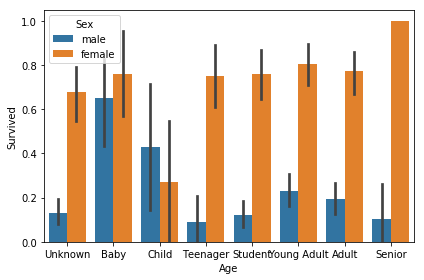

In [14]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train)
plt.tight_layout();

6.1) En la gráfica de rango de edad contra el promedio de supervivencia, el primer elemento relevante es que todas las mujeres mayores de 60 años sobrevivieron y en general las mujeres presentan un mayor promedio de supervivencia, excepto para las niñas (en el rango entre 5-12 años).

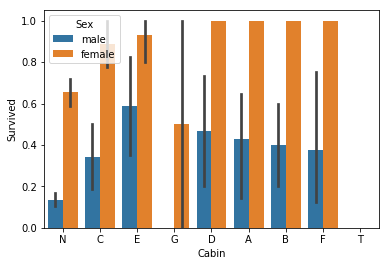

In [15]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

6.2) Para los datos de la cabina ocupada, todas las mujeres en las cabinas D,A,B, y F sobrevivieron puede ser por dos razones, la primera es que fueran mujeres pertenecientes a la primera clase y se les otorgara algún tipo de prioridad o la segunda es que hayan estado más cerca a los botes salvavidas. 

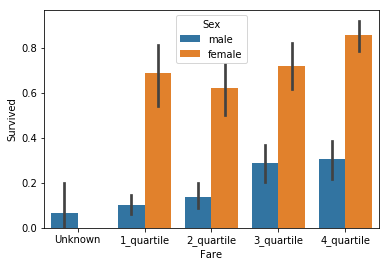

In [16]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

6.3) En esta gráfica de tarifa contra tasa de supervivencia se hace más evidente la relación entre el precio pagado (relacionado con la clase) y  la supervivencia de los pasajeros, especialemente en los hombres, que a medida que aumenta la tarifa la tasa de supervivencia aumenta. Para los casos desconocidos se asume que son personas que se colaron, razón por la cual era muy poco probable que recibieran un cupo en los botes salvavidas.

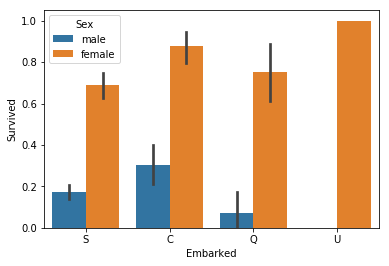

In [17]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

6.4) En la gráfica de lugar de embarcación contra supervivencia, se puede ver que los promedios más altos se encuentran para aquellas personas que embarcaron en C (Cherbourg, Francia) por lo tanto, a diferencia del código original, se decide incluir esta característica en el análisis.

7) Una forma de regularizar los datos es empleando el módulo de codificación de etiquetas del paquete de scikit-learn, que otorga valores numericos a las categorias creadas anteriormente.

In [18]:
def encode_features(df_train, df_test):
    features = ['Fare', 'Age', 'Cabin', 'Sex', 'Lname', 'NamePrefix', 'Embarked']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

In [19]:
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,2,100,12
1,2,1,1,0,0,1,0,3,2,0,182,13
2,3,1,3,0,7,0,0,0,7,2,329,9
3,4,1,1,0,7,1,0,3,2,2,267,13
4,5,0,3,1,7,0,0,1,7,2,15,12


8) Debido a los datos de prueba no contienen un valor de supervivencia para poder verificar la precisión del modelo, se realiza una partición de los datos de entrenamiento de tal forma que el entrenamiento del modelo se realizará sobre el 80% de estos, mientras que el 20% restante se usarán para medir la precisión del mismo.

In [20]:
X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test)

9) El primer clasificador a usar será Random Forest Classifier, el cual funciona diseñando un conjunto de árboles de decisión para encontrar cómo influyen las características en el resultado final. En este caso, implica que una "hoja" define la supervivencia del pasajero.
Entre los parámetros principales están:
- n_estimators, que define el número de árboles en el bosque.
- max_features, que define el máximo número de características a emplear.
- criterion, que define el método de creación de los árboles (gini, por default, o entropy).
- max_depth, que define la profundidad del árbol.
- min_samples_split, que define el mínimo número de muestras requerido para dividir un nodo interior.
- min_samples_leaf, que es el mínimo número de muestras requeridos en una hoja.


In [21]:
# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

10) Una vez se ha ajustado el modelo a los datos, se procede a realizar la predicción, para luego verificar la precisión del resultado, en comparación con el 20% de los datos ya mencionados.

In [22]:
RFpredictions = clf.predict(X_test)
print(accuracy_score(y_test, RFpredictions))

0.860335195531


11) Ahora, se probarán diferentes modelos para comparar y obtener una mejor precisión. Para cada método se dejan los parámetros que por default se tienen, a diferencia del procedimiento recién realizado.

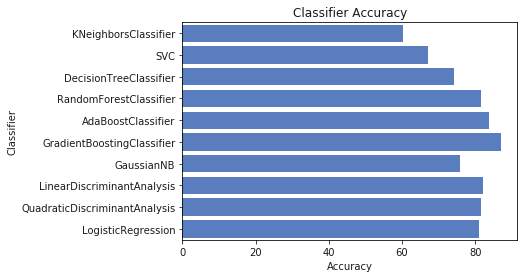

In [23]:
#Clasificadores a usar
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log1  = pd.DataFrame(columns=log_cols)

acc_dict1 = {}


#Se realiza ajuste y predicción para cada método
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict1:
        acc_dict1[name] += acc
    else:
        acc_dict1[name] = acc

# Graficación de resultados        
for clf in acc_dict1:
    acc_dict1[clf] = acc_dict1[clf]*100
    log_entry = pd.DataFrame([[clf, acc_dict1[clf]]], columns=log_cols)
    log1 = log1.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log1, color="b");

In [24]:
log1

,Classifier,Accuracy
0,KNeighborsClassifier,60.335196
0,SVC,67.039106
0,DecisionTreeClassifier,74.301676
0,RandomForestClassifier,81.564246
0,AdaBoostClassifier,83.798883
0,GradientBoostingClassifier,87.150838
0,GaussianNB,75.977654
0,LinearDiscriminantAnalysis,82.122905
0,QuadraticDiscriminantAnalysis,81.564246
0,LogisticRegression,81.005587


In [25]:
acc_dict1

{'AdaBoostClassifier': 83.798882681564251,
 'DecisionTreeClassifier': 74.30167597765363,
 'GaussianNB': 75.977653631284909,
 'GradientBoostingClassifier': 87.150837988826808,
 'KNeighborsClassifier': 60.33519553072626,
 'LinearDiscriminantAnalysis': 82.122905027932958,
 'LogisticRegression': 81.005586592178773,
 'QuadraticDiscriminantAnalysis': 81.564245810055866,
 'RandomForestClassifier': 81.564245810055866,
 'SVC': 67.039106145251395}

DISCUTIR

X.) Ahora, si se desea aumentar la precisión del modelo, se requiere reevaluar el preprocesamiento de la información. Para esto, se tomó como referencia el código de Manav Sehgal (REFERENCIAAAAAAA), que incluye el tamaño de la familia como relevante.

In [26]:
def simplify_family(df):
    df['FamSize']=df['SibSp']+df['Parch']+1
    df['IsAlone']=0
    df.loc[df['FamSize']==1,'IsAlone']=1
    return df

In [27]:
simplify_family(data_train)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix,FamSize,IsAlone
0,1,0,3,1,4,1,0,0,7,2,100,12,2,0
1,2,1,1,0,0,1,0,3,2,0,182,13,2,0
2,3,1,3,0,7,0,0,0,7,2,329,9,1,1
3,4,1,1,0,7,1,0,3,2,2,267,13,2,0
4,5,0,3,1,7,0,0,1,7,2,15,12,1,1


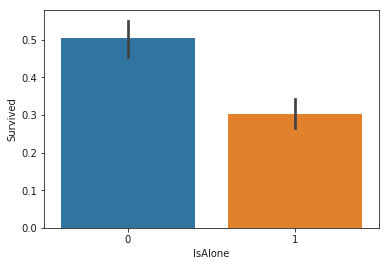

In [28]:
sns.barplot(x="IsAlone", y="Survived", data=data_train);

In [29]:
def drop_features2(df): 
    return df.drop(['SibSp', 'Parch','FamSize'], axis=1)

In [30]:
data_train2 = drop_features2(data_train)
data_train2.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Lname,NamePrefix,IsAlone
0,1,0,3,1,4,0,7,2,100,12,0
1,2,1,1,0,0,3,2,0,182,13,0
2,3,1,3,0,7,0,7,2,329,9,1
3,4,1,1,0,7,3,2,2,267,13,0
4,5,0,3,1,7,1,7,2,15,12,1


In [31]:
X_all2 = data_train2.drop(['Survived', 'PassengerId'], axis=1)
y_all2 = data_train2['Survived']
num_test = 0.20
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_all2, y_all2, test_size=num_test)

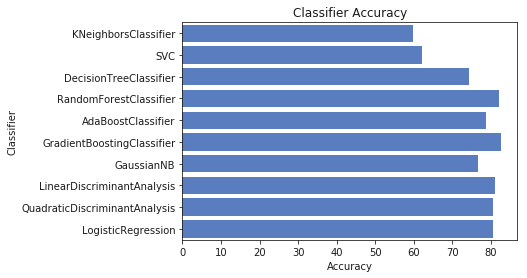

In [32]:
log_cols = ["Classifier", "Accuracy"]
log2  = pd.DataFrame(columns=log_cols)

acc_dict2 = {}


#Se realiza ajuste y predicción para cada método
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train2, y_train2)
    train_predictions2 = clf.predict(X_test2)
    acc = accuracy_score(y_test2, train_predictions2)
    if name in acc_dict2:
        acc_dict2[name] += acc
    else:
        acc_dict2[name] = acc
    
   
# Graficación de resultados        
for clf in acc_dict2:
    acc_dict2[clf] = acc_dict2[clf]*100
    log_entry = pd.DataFrame([[clf, acc_dict2[clf]]], columns=log_cols)
    log2 = log2.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log2, color="b");

In [33]:
log2

,Classifier,Accuracy
0,KNeighborsClassifier,59.776536
0,SVC,62.011173
0,DecisionTreeClassifier,74.301676
0,RandomForestClassifier,82.122905
0,AdaBoostClassifier,78.770950
0,GradientBoostingClassifier,82.681564
0,GaussianNB,76.536313
0,LinearDiscriminantAnalysis,81.005587
0,QuadraticDiscriminantAnalysis,80.446927
0,LogisticRegression,80.446927


In [34]:
log1

,Classifier,Accuracy
0,KNeighborsClassifier,60.335196
0,SVC,67.039106
0,DecisionTreeClassifier,74.301676
0,RandomForestClassifier,81.564246
0,AdaBoostClassifier,83.798883
0,GradientBoostingClassifier,87.150838
0,GaussianNB,75.977654
0,LinearDiscriminantAnalysis,82.122905
0,QuadraticDiscriminantAnalysis,81.564246
0,LogisticRegression,81.005587


A pesar de las modificaciones realizadas, las mejorías observadas son leves y no se tienen para todos los modelos usados. Los únicos que presentan cambios son Decision Tree, Gradient Boosting y Random Forest.

In [35]:
svc=SVC()
svc.fit(X_train,y_train)
Y_pred=svc.predict(X_test)
acc_svc=round(svc.score(X_train,y_train)*100,2)

In [36]:
acc_svc

97.049999999999997

In [37]:
data_test = simplify_family(data_test)
data_test = drop_features2(data_test)


In [38]:
test_X = data_test.drop(['PassengerId'],axis=1)

In [41]:

test_Y = AdaBoostClassifier().fit(X_all2,y_all2).predict( test_X )
passenger_id = data_test.PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred.csv' , index = False )